In [ ]:
import numpy as np

eval_data_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_data_complete.npy")
eval_label_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_label_complete.npy")

In [ ]:
eval_data = eval_data_original[10:-50]
eval_label = eval_label_original[10:-50]

test_data = np.concatenate((eval_data_original[:10], eval_data_original[-50:]))
test_label = np.concatenate((eval_label_original[:10], eval_label_original[-50:]))

eval_data_original = 0
eval_label_original = 0

In [ ]:
eval_data = np.concatenate((eval_data[:337], eval_data[:337], eval_data[:337], eval_data[:337], eval_data))
eval_label = np.concatenate((eval_label[:337], eval_label[:337], eval_label[:337], eval_label[:337], eval_label))
print(eval_data.shape)
print(eval_label.shape)

(3483, 22, 15000)
(3483,)


In [ ]:
idx = np.random.permutation(len(eval_data))
eval_data,eval_label = eval_data[idx], eval_label[idx]
idx = 0

In [ ]:
import torch

train_X = torch.Tensor(eval_data)
train_y = torch.Tensor(eval_label)

test_X = torch.Tensor(test_data)
test_y = torch.Tensor(test_label)

eval_data = 0
eval_label = 0
test_data = 0
test_label = 0

# 4-bit chronoNet

In [ ]:
!pip install brevitas

     |████████████████████████████████| 348kB 15.7MB/s 


In [ ]:
from typing import Any

from torch import nn
import torch.nn.functional as F

import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant

class BasicConv1d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv1d, self).__init__()
        #self.conv = qnn.QuantConv1d(in_channels, out_channels, weight_bit_width=4, bias_quant=BiasQuant, return_quant_tensor=True, bias=False, **kwargs)
        #self.conv = qnn.QuantConv1d(in_channels, out_channels, weight_bit_width=4, return_quant_tensor=False, bias=False, **kwargs)
        self.conv = qnn.QuantConv1d(in_channels, out_channels,weight_bit_width=4, **kwargs)
        #self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

        #self.relu = qnn.QuantReLU(bit_width=4, return_quant_tensor=False)

    def forward(self, x):
        x = self.conv(x)
        #x = self.bn(x)
        return F.relu(x, inplace=True)


class BasicGRU(nn.Module):
  def __init__(
      self,
      in_size:int,
      hidden_size:int,
      n_layers:int,
      **kwargs: Any
    ) -> None:
    
    super().__init__()
    
    self.num_directions = 1
    self.in_size = in_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.gru = nn.GRU(in_size, hidden_size, n_layers, batch_first=True, **kwargs)

    

    #self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)


  def set_values(self, x):
    self.batch = x.shape[0]

  
  def forward(self, x):
    self.set_values(x)
    self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)

    x, _ = self.gru(x, self.h_0)
    #print(x[:,-1])
    
    #return F.relu(x[:, -1], inplace=True)
    return x


class ChronoNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    #self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)

    conv_block = BasicConv1d
    gru_block = BasicGRU

    #x = torch.randn(50, in_size).view(-1, 50, in_size)
    #self.batch = None
    #self.set_batchsize(x)



    # CONVOLUTIONS ------ CONVOLUTIONS

    # inception 01
    self.conv_11 = conv_block(22, 32, stride=2, kernel_size=1)
    self.conv_12 = conv_block(22, 32, stride=2, kernel_size=3, padding=1)
    self.conv_13 = conv_block(22, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_1 = nn.Dropout(p=0.45)
    
    # inception 02
    self.conv_21 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_22 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_23 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_2 = nn.Dropout(p=0.45)
    
    # inception 03
    self.conv_31 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_32 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_33 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_3 = nn.Dropout(p=0.55)

    # CONVOLUTIONS ----- CONVOLUTIONS


    self.gru_1 = gru_block(96, 32, 1)
    self.gru_2 = gru_block(32, 32, 1)    
    self.gru_3 = gru_block(64, 32, 1)
    self.gru_4 = gru_block(96, 32, 1)

    x = torch.randn(22, 15000).view(-1, 22, 15000)
    self._to_linear = None
    self.conv_grus(x)

    #self.fc1 = nn.Linear(self._to_linear, 512)
    #self.fc2 = nn.Linear(512, 2)

    self.fc1 = nn.Linear(self._to_linear, 2)
 
  def set_batchsize(self, x):
    self.batch = x.shape[0]
  
  def conv_grus(self, x):
    

    # tower 01
    x_11 = self.conv_11(x)
    x_12 = self.conv_12(x)
    x_13 = self.conv_13(x)
    tower_01 = [x_11, x_12, x_13]
    #print(f'tower_01.shape = {len(tower_01)}')
    #print(f'tower_01 values = {tower_01}')
    tower_01 = torch.cat(tower_01, 1)
    tower_01 = self.dropout_1(tower_01)

    
    # tower 02
    x_21 = self.conv_21(tower_01)
    x_22 = self.conv_22(tower_01)
    x_23 = self.conv_23(tower_01)
    tower_02 = [x_21, x_22, x_23]
    #print(f'tower_02.shape = {len(tower_02)}')
    tower_02 = torch.cat(tower_02, 1)
    tower_02 = self.dropout_2(tower_02)

    
    # tower 03
    x_31 = self.conv_31(tower_02)
    x_32 = self.conv_32(tower_02)
    x_33 = self.conv_33(tower_02)
    tower_03 = [x_31, x_32, x_33]
    #print(f'tower_03.shape = {len(tower_03)}')
    #print(f'tower_03 values = {tower_03}')
    tower_03 = torch.cat(tower_03, 1)
    tower_03 = self.dropout_3(tower_03)
    

    x = tower_03.reshape(-1, tower_03.shape[2], tower_03.shape[1])


    #print(f'Tower output {x.shape}')
    
    # CONVOLUTIONS ------ GRU
        
    x_1 = self.gru_1(x)
    x_2 = self.gru_2(x_1)
    
    x_12 = [x_1, x_2]
    x_12 = torch.cat(x_12, 2)
    
    x_3 = self.gru_3(x_12)

    x_123 = [x_1, x_2, x_3]
    x_123 = torch.cat(x_123, 2)

    x_4 = self.gru_4(x_123)
    
    #print(f'GRU output {x_4.shape}')
    
    x = F.relu(x_4[:, -1], inplace=True)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]#*x[0].shape[1]
      #print(x[0].shape)
      #print(self._to_linear)

    return x
  
  def forward(self, x):
    #x = self.quant_inp(x)
    x = self.conv_grus(x)
    x = x.reshape(-1, self._to_linear)
    #x = F.relu(self.fc1(x))
    #x = self.fc2(x)

    x = self.fc1(x)
  
    return F.softmax(x, dim=1)

chrono_net = ChronoNet()


In [ ]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(chrono_net.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()
#loss_function = CategoricalCrossEntropyLoss()
#loss_function = nn.sparse_categorical_crossentropy()

def fwd_pass(X, y, train=False):
  if train:
    chrono_net.zero_grad()
  outputs = chrono_net(X)
  #outputs = torch.Tensor(outputs).long()
  #print(outputs, y)
  matches = [torch.argmax(i) == j for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  #random_start = np.random.randint(len(test_X) - size)
  #X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  X, y = test_X, test_y
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 22, 15000)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

  0%|          | 0/27 [00:00<?, ?it/s]

0.18333333333333332 tensor(0.7014)
model-1620570328


100%|██████████| 27/27 [11:09<00:00, 24.79s/it]


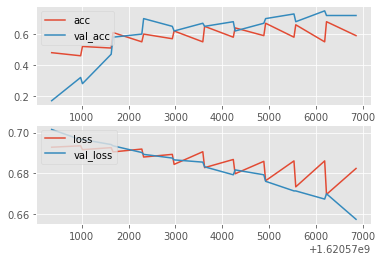

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


# 2-bit

In [ ]:
from typing import Any

from torch import nn
import torch.nn.functional as F

import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant

class BasicConv1d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv1d, self).__init__()
        #self.conv = qnn.QuantConv1d(in_channels, out_channels, weight_bit_width=4, bias_quant=BiasQuant, return_quant_tensor=True, bias=False, **kwargs)
        #self.conv = qnn.QuantConv1d(in_channels, out_channels, weight_bit_width=4, return_quant_tensor=False, bias=False, **kwargs)
        self.conv = qnn.QuantConv1d(in_channels, out_channels,weight_bit_width=2, **kwargs)
        #self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

        #self.relu = qnn.QuantReLU(bit_width=4, return_quant_tensor=False)

    def forward(self, x):
        x = self.conv(x)
        #x = self.bn(x)
        return F.relu(x, inplace=True)


class BasicGRU(nn.Module):
  def __init__(
      self,
      in_size:int,
      hidden_size:int,
      n_layers:int,
      **kwargs: Any
    ) -> None:
    
    super().__init__()
    
    self.num_directions = 1
    self.in_size = in_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.gru = nn.GRU(in_size, hidden_size, n_layers, batch_first=True, **kwargs)

    

    #self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)


  def set_values(self, x):
    self.batch = x.shape[0]

  
  def forward(self, x):
    self.set_values(x)
    self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)

    x, _ = self.gru(x, self.h_0)
    #print(x[:,-1])
    
    #return F.relu(x[:, -1], inplace=True)
    return x


class ChronoNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    #self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)

    conv_block = BasicConv1d
    gru_block = BasicGRU

    #x = torch.randn(50, in_size).view(-1, 50, in_size)
    #self.batch = None
    #self.set_batchsize(x)



    # CONVOLUTIONS ------ CONVOLUTIONS

    # inception 01
    self.conv_11 = conv_block(22, 32, stride=2, kernel_size=1)
    self.conv_12 = conv_block(22, 32, stride=2, kernel_size=3, padding=1)
    self.conv_13 = conv_block(22, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_1 = nn.Dropout(p=0.45)
    
    # inception 02
    self.conv_21 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_22 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_23 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_2 = nn.Dropout(p=0.45)
    
    # inception 03
    self.conv_31 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_32 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_33 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_3 = nn.Dropout(p=0.55)

    # CONVOLUTIONS ----- CONVOLUTIONS


    self.gru_1 = gru_block(96, 32, 1)
    self.gru_2 = gru_block(32, 32, 1)    
    self.gru_3 = gru_block(64, 32, 1)
    self.gru_4 = gru_block(96, 32, 1)

    x = torch.randn(22, 15000).view(-1, 22, 15000)
    self._to_linear = None
    self.conv_grus(x)

    #self.fc1 = nn.Linear(self._to_linear, 512)
    #self.fc2 = nn.Linear(512, 2)

    self.fc1 = nn.Linear(self._to_linear, 2)
 
  def set_batchsize(self, x):
    self.batch = x.shape[0]
  
  def conv_grus(self, x):
    

    # tower 01
    x_11 = self.conv_11(x)
    x_12 = self.conv_12(x)
    x_13 = self.conv_13(x)
    tower_01 = [x_11, x_12, x_13]
    #print(f'tower_01.shape = {len(tower_01)}')
    #print(f'tower_01 values = {tower_01}')
    tower_01 = torch.cat(tower_01, 1)
    tower_01 = self.dropout_1(tower_01)

    
    # tower 02
    x_21 = self.conv_21(tower_01)
    x_22 = self.conv_22(tower_01)
    x_23 = self.conv_23(tower_01)
    tower_02 = [x_21, x_22, x_23]
    #print(f'tower_02.shape = {len(tower_02)}')
    tower_02 = torch.cat(tower_02, 1)
    tower_02 = self.dropout_2(tower_02)

    
    # tower 03
    x_31 = self.conv_31(tower_02)
    x_32 = self.conv_32(tower_02)
    x_33 = self.conv_33(tower_02)
    tower_03 = [x_31, x_32, x_33]
    #print(f'tower_03.shape = {len(tower_03)}')
    #print(f'tower_03 values = {tower_03}')
    tower_03 = torch.cat(tower_03, 1)
    tower_03 = self.dropout_3(tower_03)
    

    x = tower_03.reshape(-1, tower_03.shape[2], tower_03.shape[1])


    #print(f'Tower output {x.shape}')
    
    # CONVOLUTIONS ------ GRU
        
    x_1 = self.gru_1(x)
    x_2 = self.gru_2(x_1)
    
    x_12 = [x_1, x_2]
    x_12 = torch.cat(x_12, 2)
    
    x_3 = self.gru_3(x_12)

    x_123 = [x_1, x_2, x_3]
    x_123 = torch.cat(x_123, 2)

    x_4 = self.gru_4(x_123)
    
    #print(f'GRU output {x_4.shape}')
    
    x = F.relu(x_4[:, -1], inplace=True)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]#*x[0].shape[1]
      #print(x[0].shape)
      #print(self._to_linear)

    return x
  
  def forward(self, x):
    #x = self.quant_inp(x)
    x = self.conv_grus(x)
    x = x.reshape(-1, self._to_linear)
    #x = F.relu(self.fc1(x))
    #x = self.fc2(x)

    x = self.fc1(x)
  
    return F.softmax(x, dim=1)

chrono_net = ChronoNet()


In [ ]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(chrono_net.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()
#loss_function = CategoricalCrossEntropyLoss()
#loss_function = nn.sparse_categorical_crossentropy()

def fwd_pass(X, y, train=False):
  if train:
    chrono_net.zero_grad()
  outputs = chrono_net(X)
  #outputs = torch.Tensor(outputs).long()
  #print(outputs, y)
  matches = [torch.argmax(i) == j for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  #random_start = np.random.randint(len(test_X) - size)
  #X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  X, y = test_X, test_y
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 22, 15000)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

  0%|          | 0/27 [00:00<?, ?it/s]

0.16666666666666666 tensor(0.7022)
model-1620576869


100%|██████████| 27/27 [11:26<00:00, 25.43s/it]


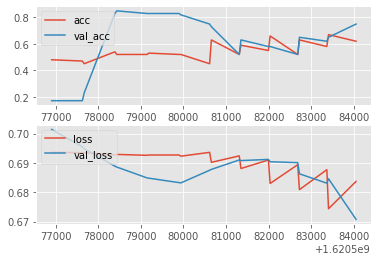

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


# 1-bit

In [ ]:
from typing import Any

from torch import nn
import torch.nn.functional as F

import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant

class BasicConv1d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv1d, self).__init__()
        #self.conv = qnn.QuantConv1d(in_channels, out_channels, weight_bit_width=4, bias_quant=BiasQuant, return_quant_tensor=True, bias=False, **kwargs)
        #self.conv = qnn.QuantConv1d(in_channels, out_channels, weight_bit_width=4, return_quant_tensor=False, bias=False, **kwargs)
        self.conv = qnn.QuantConv1d(in_channels, out_channels,weight_bit_width=1, **kwargs)
        #self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

        #self.relu = qnn.QuantReLU(bit_width=4, return_quant_tensor=False)

    def forward(self, x):
        x = self.conv(x)
        #x = self.bn(x)
        return F.relu(x, inplace=True)


class BasicGRU(nn.Module):
  def __init__(
      self,
      in_size:int,
      hidden_size:int,
      n_layers:int,
      **kwargs: Any
    ) -> None:
    
    super().__init__()
    
    self.num_directions = 1
    self.in_size = in_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.gru = nn.GRU(in_size, hidden_size, n_layers, batch_first=True, **kwargs)

    

    #self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)


  def set_values(self, x):
    self.batch = x.shape[0]

  
  def forward(self, x):
    self.set_values(x)
    self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)

    x, _ = self.gru(x, self.h_0)
    #print(x[:,-1])
    
    #return F.relu(x[:, -1], inplace=True)
    return x


class ChronoNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    #self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)

    conv_block = BasicConv1d
    gru_block = BasicGRU

    #x = torch.randn(50, in_size).view(-1, 50, in_size)
    #self.batch = None
    #self.set_batchsize(x)



    # CONVOLUTIONS ------ CONVOLUTIONS

    # inception 01
    self.conv_11 = conv_block(22, 32, stride=2, kernel_size=1)
    self.conv_12 = conv_block(22, 32, stride=2, kernel_size=3, padding=1)
    self.conv_13 = conv_block(22, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_1 = nn.Dropout(p=0.45)
    
    # inception 02
    self.conv_21 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_22 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_23 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_2 = nn.Dropout(p=0.45)
    
    # inception 03
    self.conv_31 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_32 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_33 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_3 = nn.Dropout(p=0.55)

    # CONVOLUTIONS ----- CONVOLUTIONS


    self.gru_1 = gru_block(96, 32, 1)
    self.gru_2 = gru_block(32, 32, 1)    
    self.gru_3 = gru_block(64, 32, 1)
    self.gru_4 = gru_block(96, 32, 1)

    x = torch.randn(22, 15000).view(-1, 22, 15000)
    self._to_linear = None
    self.conv_grus(x)

    #self.fc1 = nn.Linear(self._to_linear, 512)
    #self.fc2 = nn.Linear(512, 2)

    self.fc1 = nn.Linear(self._to_linear, 2)
 
  def set_batchsize(self, x):
    self.batch = x.shape[0]
  
  def conv_grus(self, x):
    

    # tower 01
    x_11 = self.conv_11(x)
    x_12 = self.conv_12(x)
    x_13 = self.conv_13(x)
    tower_01 = [x_11, x_12, x_13]
    #print(f'tower_01.shape = {len(tower_01)}')
    #print(f'tower_01 values = {tower_01}')
    tower_01 = torch.cat(tower_01, 1)
    tower_01 = self.dropout_1(tower_01)

    
    # tower 02
    x_21 = self.conv_21(tower_01)
    x_22 = self.conv_22(tower_01)
    x_23 = self.conv_23(tower_01)
    tower_02 = [x_21, x_22, x_23]
    #print(f'tower_02.shape = {len(tower_02)}')
    tower_02 = torch.cat(tower_02, 1)
    tower_02 = self.dropout_2(tower_02)

    
    # tower 03
    x_31 = self.conv_31(tower_02)
    x_32 = self.conv_32(tower_02)
    x_33 = self.conv_33(tower_02)
    tower_03 = [x_31, x_32, x_33]
    #print(f'tower_03.shape = {len(tower_03)}')
    #print(f'tower_03 values = {tower_03}')
    tower_03 = torch.cat(tower_03, 1)
    tower_03 = self.dropout_3(tower_03)
    

    x = tower_03.reshape(-1, tower_03.shape[2], tower_03.shape[1])


    #print(f'Tower output {x.shape}')
    
    # CONVOLUTIONS ------ GRU
        
    x_1 = self.gru_1(x)
    x_2 = self.gru_2(x_1)
    
    x_12 = [x_1, x_2]
    x_12 = torch.cat(x_12, 2)
    
    x_3 = self.gru_3(x_12)

    x_123 = [x_1, x_2, x_3]
    x_123 = torch.cat(x_123, 2)

    x_4 = self.gru_4(x_123)
    
    #print(f'GRU output {x_4.shape}')
    
    x = F.relu(x_4[:, -1], inplace=True)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]#*x[0].shape[1]
      #print(x[0].shape)
      #print(self._to_linear)

    return x
  
  def forward(self, x):
    #x = self.quant_inp(x)
    x = self.conv_grus(x)
    x = x.reshape(-1, self._to_linear)
    #x = F.relu(self.fc1(x))
    #x = self.fc2(x)

    x = self.fc1(x)
  
    return F.softmax(x, dim=1)

chrono_net = ChronoNet()


In [ ]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(chrono_net.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()
#loss_function = CategoricalCrossEntropyLoss()
#loss_function = nn.sparse_categorical_crossentropy()

def fwd_pass(X, y, train=False):
  if train:
    chrono_net.zero_grad()
  outputs = chrono_net(X)
  #outputs = torch.Tensor(outputs).long()
  #print(outputs, y)
  matches = [torch.argmax(i) == j for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  #random_start = np.random.randint(len(test_X) - size)
  #X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  X, y = test_X, test_y
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 22, 15000)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

  0%|          | 0/27 [00:00<?, ?it/s]

0.8333333333333334 tensor(nan)
model-1620584741


100%|██████████| 27/27 [06:44<00:00, 14.98s/it]


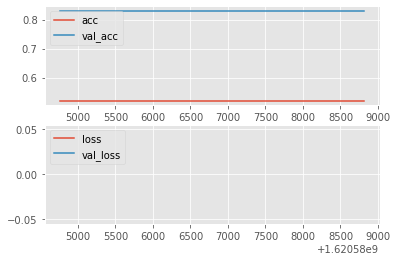

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      
